In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


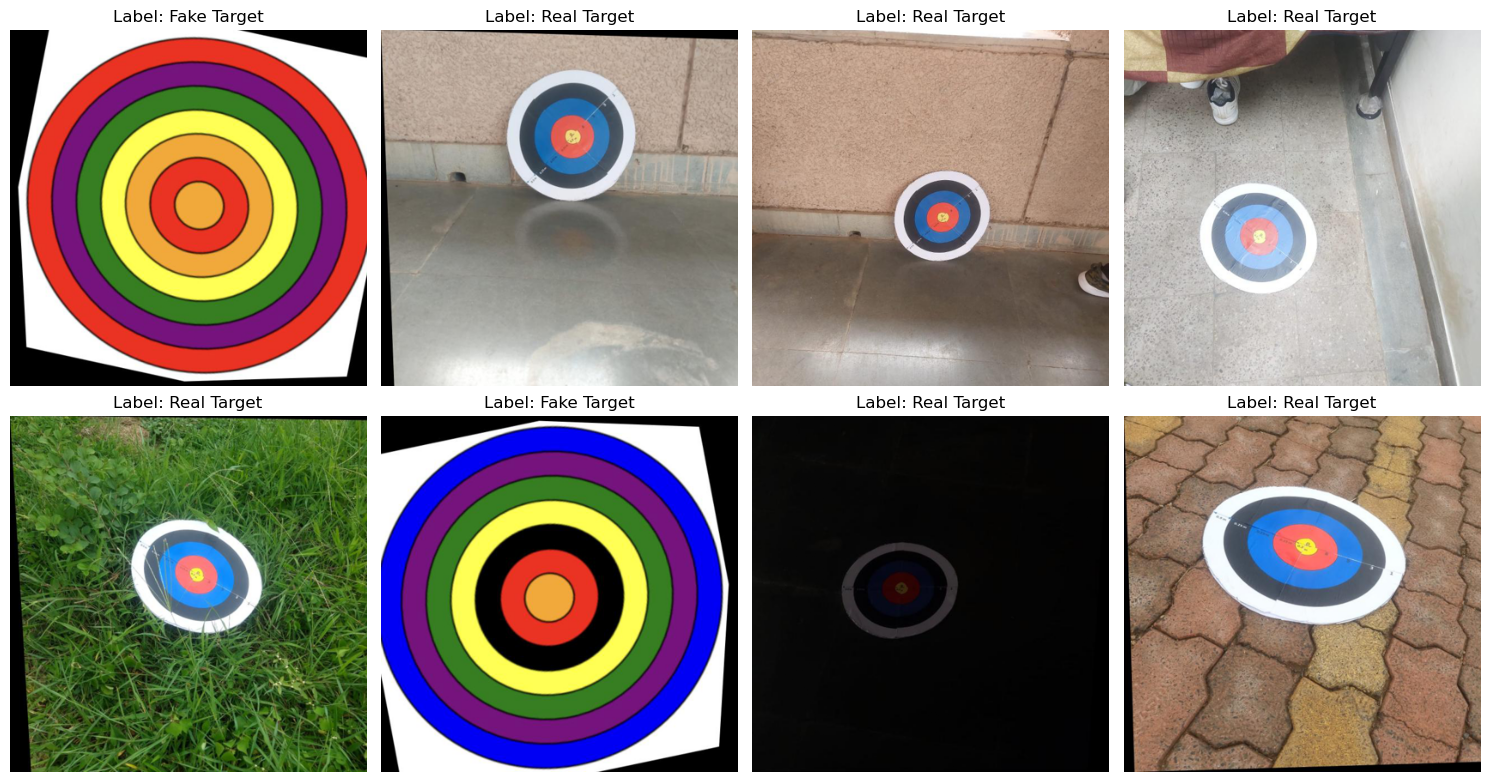

Total images in dataset: 213
Number of real targets (1): 163
Number of fake targets (0): 50


In [16]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Constants
IMG_SIZE = 416
BASE_PATH = '/Users/rohanshenoy/Desktop/Aerothon.v3i.yolokeras'

def load_and_display_data(num_images=8):
    """
    Load and preprocess the dataset, and display random images with their labels.

    Args:
        num_images: Number of random images to display (default=8)
    
    Returns:
        images: Array of preprocessed images
        labels: Array of corresponding labels
    """
    images = []
    labels = []
    
    def process_directory(path, label):
        for img_name in os.listdir(path):
            if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                img_path = os.path.join(path, img_name)
                img = Image.open(img_path).convert("RGB")
                img = img.resize((IMG_SIZE, IMG_SIZE))
                img_array = np.array(img) / 255.0  # Normalize
                images.append(img_array)
                labels.append(label)
    
    # Process fake targets (class 0)
    fake_path = os.path.join(BASE_PATH, '0')
    process_directory(fake_path, 0)
    
    # Process real targets (class 1)
    real_path = os.path.join(BASE_PATH, '1')
    process_directory(real_path, 1)
    
    images = np.array(images, dtype=np.float32)
    labels = np.array(labels, dtype=np.int32)
    
    # Display random images
    fig = plt.figure(figsize=(15, 8))
    indices = np.random.randint(0, len(images), num_images)
    
    for idx, i in enumerate(indices):
        ax = fig.add_subplot(2, 4, idx + 1)
        ax.imshow(images[i])
        label_text = "Real Target" if labels[i] == 1 else "Fake Target"
        ax.set_title(f"Label: {label_text}")
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Total images in dataset: {len(images)}")
    print(f"Number of real targets (1): {np.sum(labels)}")
    print(f"Number of fake targets (0): {len(labels) - np.sum(labels)}")
    
    return images, labels

# Call the combined function
X, y = load_and_display_data()


Epoch 1/5
3/3 [==============================] - 6s 2s/step - loss: 6.4323 - accuracy: 0.5000 - val_loss: 13.9478 - val_accuracy: 0.5500
Epoch 2/5
3/3 [==============================] - 5s 1s/step - loss: 3.2617 - accuracy: 0.8875 - val_loss: 0.0085 - val_accuracy: 1.0000
Epoch 3/5
3/3 [==============================] - 5s 2s/step - loss: 1.9093 - accuracy: 0.8625 - val_loss: 2.9797e-05 - val_accuracy: 1.0000
Epoch 4/5
3/3 [==============================] - 5s 1s/step - loss: 1.1771 - accuracy: 0.9500 - val_loss: 6.6590e-10 - val_accuracy: 1.0000
Epoch 5/5
1/1 [==============================] - 0s 189ms/step - loss: 2.7633e-14 - accuracy: 1.0000

Test accuracy: 1.0000


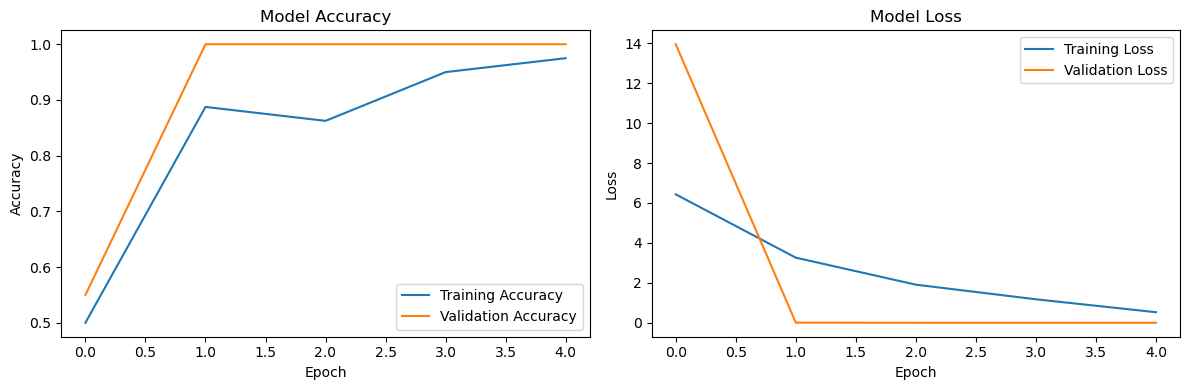


Model saved as 'target_detection_model.h5'


In [12]:
def create_yolo_model():
    model = models.Sequential([
        # First block
        layers.Conv2D(16, (3, 3), padding='same', activation='relu', 
                     input_shape=(IMG_SIZE, IMG_SIZE, 3)),
        layers.MaxPooling2D((2, 2)),
        
        # Second block
        layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D((2, 2)),
        
        
        # Dense layers
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

def train_model():
    X, y = load_and_preprocess_data()
    
    # Balance dataset if imbalanced
    unique, counts = np.unique(y, return_counts=True)
    min_class_count = min(counts)
    indices_0 = np.where(y == 0)[0]
    indices_1 = np.where(y == 1)[0]
    
    indices_0 = np.random.choice(indices_0, min_class_count, replace=False)
    indices_1 = np.random.choice(indices_1, min_class_count, replace=False)
    balanced_indices = np.concatenate([indices_0, indices_1])
    
    X = X[balanced_indices]
    y = y[balanced_indices]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    model = create_yolo_model()
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                 loss='binary_crossentropy',
                 metrics=['accuracy'])
    
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    )
    
    history = model.fit(
        X_train, y_train,
        batch_size=32,
        epochs=5,
        validation_data=(X_test, y_test),
        callbacks=[early_stopping]
    )
    
    return model, history, X_test, y_test

def evaluate_and_plot(history, model, X_test, y_test):
    """
    Evaluate the model and plot training history.
    """
    # Evaluate the model
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print(f"\nTest accuracy: {test_accuracy:.4f}")
    
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Train the model
    model, history, X_test, y_test = train_model()
    
    # Evaluate and visualize results
    evaluate_and_plot(history, model, X_test, y_test)
    
    # Save the model
    model.save('target_detection_model.h5')
    print("\nModel saved as 'target_detection_model.h5'")


Testing predictions...


1/1 [==============================] - 0s 89ms/step


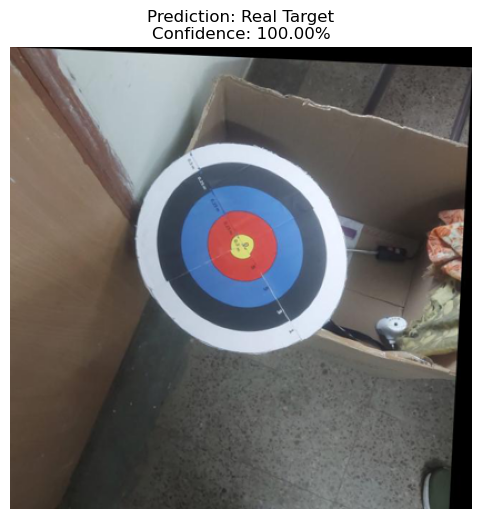


Image: WhatsApp-Image-2023-08-18-at-19-32-29_jpeg.rf.acc9ee2419b47491d9b75f9642be0672.jpg
Prediction: Real Target
Confidence: 100.00%
1/1 [==============================] - 0s 28ms/step


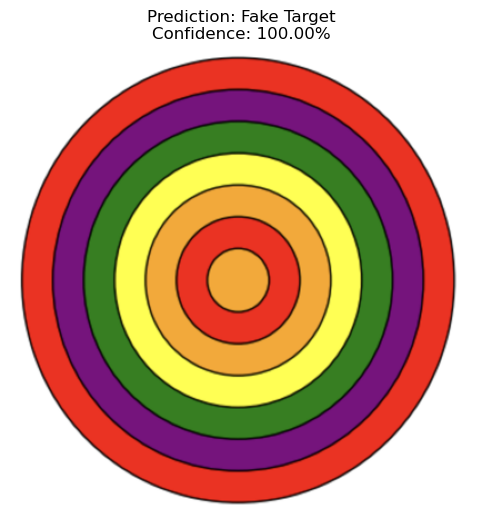


Image: Screenshot 2025-01-21 at 7.31.14 PM copy.png
Prediction: Fake Target
Confidence: 100.00%
1/1 [==============================] - 0s 28ms/step


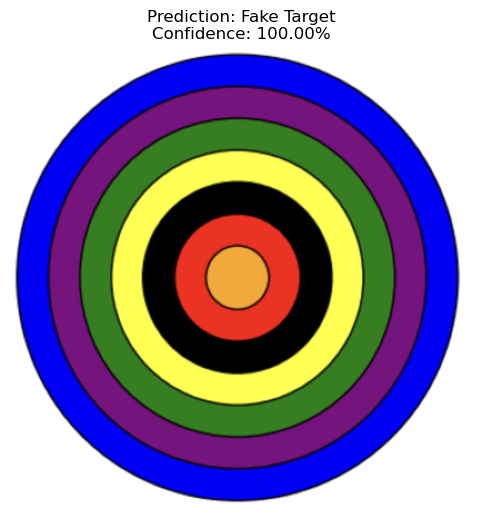


Image: Screenshot 2025-01-21 at 7.17.57 PM.png
Prediction: Fake Target
Confidence: 100.00%
1/1 [==============================] - 0s 28ms/step


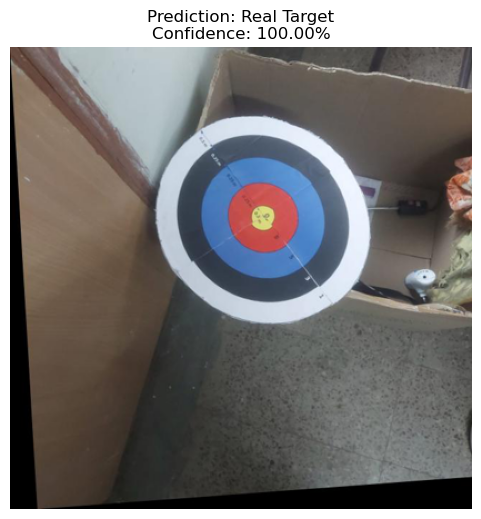


Image: WhatsApp-Image-2023-08-18-at-19-32-29_jpeg.rf.049457a1dafd55f5cb52c3625926adef.jpg
Prediction: Real Target
Confidence: 100.00%
1/1 [==============================] - 0s 27ms/step


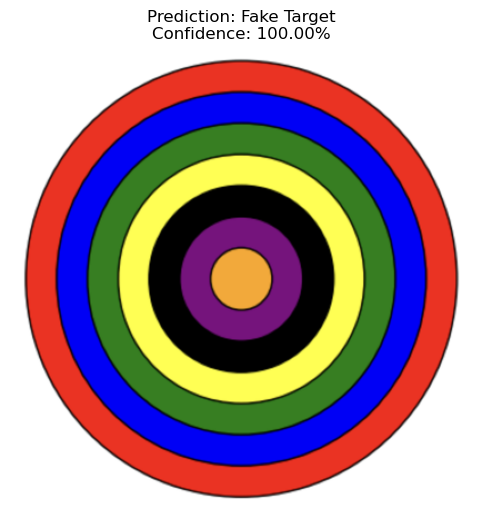


Image: Screenshot 2025-01-21 at 7.16.19 PM.png
Prediction: Fake Target
Confidence: 100.00%
1/1 [==============================] - 0s 27ms/step


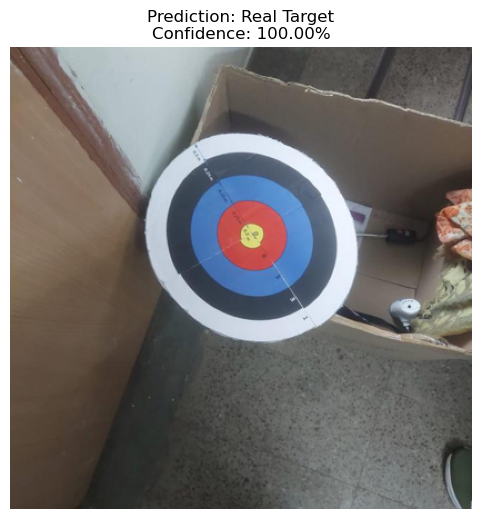


Image: WhatsApp-Image-2023-08-18-at-19-32-29_jpeg.rf.e83b8e4fef41131304ab4de65bf911ce.jpg
Prediction: Real Target
Confidence: 100.00%


In [13]:

def predict_single_image(model, image_path):
    """
    Make prediction on a single image.
    """
    img = Image.open(image_path).convert("RGB")
    img = img.resize((IMG_SIZE, IMG_SIZE))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    prediction = model.predict(img_array)[0][0]
    label = "Real Target" if prediction > 0.5 else "Fake Target"
    confidence = prediction if prediction > 0.5 else 1 - prediction
    
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title(f"Prediction: {label}\nConfidence: {confidence:.2%}")
    plt.axis('off')
    plt.show()
    
    return label, confidence

def test_predictions(model_path, test_images_dir):
    """
    Test model predictions on multiple images.
    """
    model = tf.keras.models.load_model(model_path)
    results = []
    
    for img_name in os.listdir(test_images_dir):
        if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(test_images_dir, img_name)
            label, confidence = predict_single_image(model, img_path)
            results.append({
                'image': img_name,
                'prediction': label,
                'confidence': confidence
            })
            print(f"\nImage: {img_name}")
            print(f"Prediction: {label}")
            print(f"Confidence: {confidence:.2%}")
    
    return results

if __name__ == "__main__":
    # Previous training code...
    
    # Test predictions
    print("\nTesting predictions...")
    test_dir = os.path.join(BASE_PATH, 'test_images')  # Create this directory and add test images
    results = test_predictions('target_detection_model.h5', test_dir)